# Abstraction-Based Text Summarization Using Sequence to Sequence Algorithm

In [1]:
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook

import nltk
from nltk.corpus import stopwords

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras import backend as K 
K.clear_session() 

Using TensorFlow backend.


## Load Datasets

In [4]:
# datasets grasp from here www.kaggle.com/snap/amazon-fine-food-reviews
df_reviews = pd.read_csv("./datasets/amazon-fine-food-reviews.csv", nrows=100000) # try more rows for much better result
df_reviews[['Text', 'Summary']].head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


## Preprocess Datasets

#### 1) Dropping duplicates and NaN values

In [5]:
df_reviews = df_reviews.drop_duplicates(subset=['Summary'])
df_reviews = df_reviews.dropna(axis=0)

In [6]:
df_reviews = df_reviews.drop_duplicates(subset=['Text'])
df_reviews = df_reviews.dropna(axis=0)

#### 2) Cleaning up stop words, contractions, non-alphanumeric and others

In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
pickle_file = open('../../others/contraction_dictionary.pickle','rb')
contraction_dict = pickle.load(pickle_file)

In [9]:
def clean_up_text(sentence):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contraction_dict[word] if word in contraction_dict else word for word in sentence.split(' ')])
    sentence = re.sub(r"'s\b",'', sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) 
    
    tokens = [word for word in sentence.split() if not word in stop_words]
    words = []
    for word in tokens:
        if len(word) >= 3:
            words.append(word)
    
    return (' '.join(words)).strip()

In [10]:
cleaned_text = []
for sentence in tqdm_notebook(df_reviews['Text']): cleaned_text.append(clean_up_text(sentence))
df_reviews['Cleaned Text'] = cleaned_text

In [11]:
def clean_up_summary(sentence):
    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contraction_dict[word] if word in contraction_dict else word for word in sentence.split(' ')])
    sentence = re.sub(r"'s\b",'', sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = sentence.lower()
    
    tokens = sentence.split()
    sentence = ''
    for word in tokens:
        if len(word) > 1:
            sentence += word + ' '
    
    return sentence

In [12]:
cleaned_summary = []
for sentence in tqdm_notebook(df_reviews['Summary']): cleaned_summary.append(clean_up_summary(sentence))
df_reviews['Cleaned Summary'] = cleaned_summary
df_reviews['Cleaned Summary'] = df_reviews['Cleaned Summary'].replace('', np.nan)
df_reviews = df_reviews.dropna(axis=0)
df_reviews['Cleaned Summary'] = df_reviews['Cleaned Summary'].apply(lambda x : '_START_ ' + x + ' _END_')

In [13]:
df_reviews[['Text', 'Cleaned Text', 'Summary', 'Cleaned Summary']].head()

,Text,Cleaned Text,Summary,Cleaned Summary
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,Good Quality Dog Food,_START_ good quality dog food _END_
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,Not as Advertised,_START_ not as advertised _END_
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,"""Delight"" says it all",_START_ delight says it all _END_
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,Cough Medicine,_START_ cough medicine _END_
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,Great taffy,_START_ great taffy _END_


In [14]:
for i in range(5):
    print("Text:", df_reviews['Cleaned Text'][i+1])
    print("Summary:", df_reviews['Cleaned Summary'][i+1])
    print("\n")

Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Text: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Text: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: _START_ great taffy  _END_


Text: got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces ki

#### 3) Setting maximum length of the reviews and the summary based on the distribution of sequences

In [15]:
text_word_count = []
summary_word_count = []

for sentence in df_reviews['Cleaned Text']: text_word_count.append(len(sentence.split()))
for sentence in df_reviews['Cleaned Summary']: summary_word_count.append(len(sentence.split()))

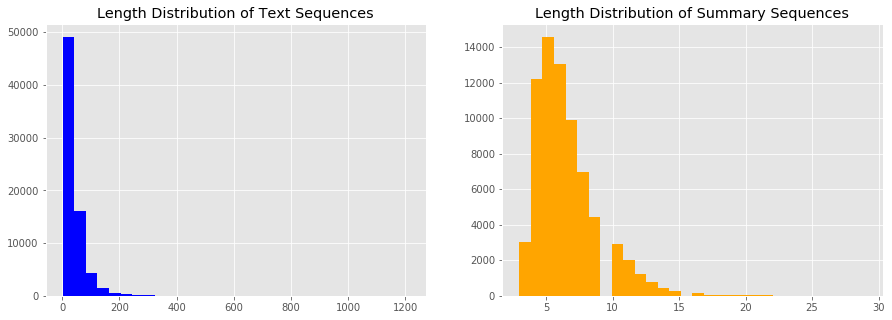

In [16]:
df_dist_sequences = pd.DataFrame({ 'Text': text_word_count, 'Summary': summary_word_count })

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
plt.title('Length Distribution of Text Sequences')
ax1.hist(x= df_dist_sequences['Text'], bins=30, color='Blue')
ax2 = fig.add_subplot(1,2,2)
plt.title('Length Distribution of Summary Sequences')
ax2.hist(x= df_dist_sequences['Summary'], bins = 30, color='Orange')

plt.savefig('./images/histogram-length-distribution-of-sequences')
plt.show()

In [17]:
MAX_LEN_TEXT = 80
MAX_LEN_SUMMARY = 10

#### 4) Splitting datasets into training and validation set

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
TEST_SIZE = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(df_reviews['Cleaned Text'], df_reviews['Cleaned Summary'], test_size=TEST_SIZE, shuffle=True, random_state=10)

#### 5) Preparing The Tokenizer

In [20]:
# preparing a tokenizer for text on training data
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# converting text sequences into integer sequences
X_train = X_tokenizer.texts_to_sequences(X_train)
X_valid = X_tokenizer.texts_to_sequences(X_valid)

# padding zero up to maximum length
X_train = pad_sequences(X_train, maxlen=MAX_LEN_TEXT, padding='post')
X_valid = pad_sequences(X_valid, maxlen=MAX_LEN_TEXT, padding='post')

# calculating vocabulary size
X_vocab_size = len(X_tokenizer.word_index) + 1

In [21]:
# preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

# converting summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train)
y_valid = y_tokenizer.texts_to_sequences(y_valid)

# padding zero up to maximum length
y_train = pad_sequences(y_train, maxlen=MAX_LEN_SUMMARY, padding='post')
y_valid = pad_sequences(y_valid, maxlen=MAX_LEN_SUMMARY, padding='post')

# calculating vocabulary size
y_vocab_size = len(y_tokenizer.word_index) + 1

## Build Seq2seq Network

In [22]:
from attention import AttentionLayer

In [23]:
LATENT_DIM = 500 

In [24]:
# INITIALIZE NETWORK ARCHITECTURE FOR TRAINING PROCESS
# -----------------------------------------------------

# Encoder 
encoder_inputs = Input(shape=(MAX_LEN_TEXT,)) 
encoder_embedding_layer = Embedding(X_vocab_size, LATENT_DIM, trainable=True)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

# The Encoder
encoder_lstm_layer = LSTM(LATENT_DIM, return_sequences=True, return_state=True) 
encoder_output, state_h, state_c = encoder_lstm_layer(encoder_embedding) 
encoder_lstm_layer = LSTM(LATENT_DIM, return_sequences=True, return_state=True) 
encoder_output, state_h, state_c = encoder_lstm_layer(encoder_output) 
encoder_lstm_layer = LSTM(LATENT_DIM, return_state=True, return_sequences=True) 
encoder_context_vector, state_h, state_c = encoder_lstm_layer(encoder_output) 

# The Decoder
decoder_inputs = Input(shape=(None,)) 
decoder_embedding_layer = Embedding(y_vocab_size, LATENT_DIM, trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm_layer = LSTM(LATENT_DIM, return_sequences=True, return_state=True) 
decoder_outputs, decoder_forward_state, decoder_backward_state = decoder_lstm_layer(decoder_embedding, initial_state=[state_h, state_c]) 

# Attention Layer
attention_layer = AttentionLayer(name='attention_layer') 
attention_outputs, attention_states = attention_layer([encoder_context_vector, decoder_outputs]) 

# concatinating The LSTM-Decoder outputs and Attention outputs
decoder_attention_outputs = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_outputs])

# Dense layer
decoder_dense_layer = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense_layer(decoder_attention_outputs) 

# defining the network
seq2seq_net = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [25]:
seq2seq_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      24483500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

## Set Loss Function

In [26]:
seq2seq_net.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

## Set Early Stopping

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=True)

## Train The Network

In [28]:
BATCH_SIZE = 512
N_EPOCHS = 50

In [29]:
# training data
X_to_train = [X_train, y_train[:,:-1]]
y_to_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:]

# validation data
X_to_valid = [X_valid, y_valid[:,:-1]]
y_to_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)[:,1:]

In [30]:
seq2seq_history = seq2seq_net.fit(X_to_train, y_to_train, validation_data=(X_to_valid, y_to_valid), epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=True)

Train on 64965 samples, validate on 7219 samples
Epoch 1/50
64965/64965 [==============================] - 6549s 101ms/step - loss: 3.6589 - val_loss: 3.2116
Epoch 2/50
64965/64965 [==============================] - 6470s 100ms/step - loss: 3.1944 - val_loss: 2.9485
Epoch 3/50
64965/64965 [==============================] - 7088s 109ms/step - loss: 2.9583 - val_loss: 2.7816
Epoch 4/50
64965/64965 [==============================] - 7046s 108ms/step - loss: 2.7709 - val_loss: 2.6731
Epoch 5/50
64965/64965 [==============================] - 6816s 105ms/step - loss: 2.6234 - val_loss: 2.6018
Epoch 6/50
64965/64965 [==============================] - 7328s 113ms/step - loss: 2.4978 - val_loss: 2.5334
Epoch 7/50
64965/64965 [==============================] - 7216s 111ms/step - loss: 2.3831 - val_loss: 2.4956
Epoch 8/50
64965/64965 [==============================] - 7387s 114ms/step - loss: 2.2766 - val_loss: 2.4763
Epoch 9/50
64965/64965 [==============================] - 6725s 104ms/step - lo

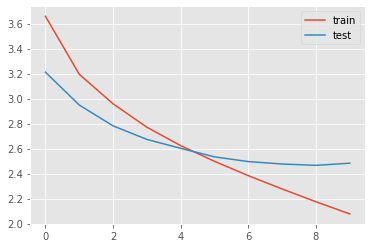

In [31]:
plt.plot(seq2seq_history.history['loss'], label='train') 
plt.plot(seq2seq_history.history['val_loss'], label='test') 
plt.legend()
plt.savefig('./images/train-valid-loss-of-seq2seq-network')
plt.show()

## Get Summary

In [32]:
source_word2index = X_tokenizer.word_index
source_index2word = { index: word for word, index in source_word2index.items() }

target_word2index = y_tokenizer.word_index
target_index2word = { index: word for word, index in target_word2index.items() }

In [33]:
# INITIALIZE NETWORK ARCHITECTURE FOR INFERENCING PROCESS
# --------------------------------------------------------

# encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_context_vector, state_h, state_c])

# decoder inference, below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_hidden_state_input = Input(shape=(MAX_LEN_TEXT, LATENT_DIM))

# geting the embeddings of the decoder sequence
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs)

# setting the initial states to the states from the previous time step, to predict the next word in the sequence
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer(decoder_embedding_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attention_outputs, attention_states = attention_layer([decoder_hidden_state_input, decoder_outputs_inf])

# concatinating The LSTM-Decoder outputs and Attention outputs
decoder_attention_outputs = Concatenate(axis=-1, name='concat_layer_inf')([decoder_outputs_inf, attention_outputs])

# Dense softmax layer to generate probability distribution over the target vocabulary
decoder_outputs = decoder_dense_layer(decoder_attention_outputs)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs_inf] + [state_h_inf, state_c_inf])

In [34]:
def decode_sequence(input_sequence):
    
    # encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # generating empty target sequence of length 1
    target_sequence = np.zeros((1,1))

    # choosing the 'start' word as the first word of the target sequence
    target_sequence[0, 0] = target_word2index['start']

    stop_condition = False
    
    decoded_sequence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_sequence] + [e_out, e_h, e_c])

        # sampling a token and using greedy approach
        predicted_word_index = np.argmax(output_tokens[0, -1, :])
        predicted_word = target_index2word[predicted_word_index]

        if(predicted_word != 'end'):
            decoded_sequence += ' ' + predicted_word

            # stopping process when either hiting max length or finding stop word
            if (predicted_word == 'end' or len(decoded_sequence.split()) >= (MAX_LEN_SUMMARY-1)):
                stop_condition = True

        # updating the target sequence of length 1
        target_sequence = np.zeros((1,1))
        target_sequence[0, 0] = predicted_word_index

        # updating internal states
        e_h, e_c = h, c

    return decoded_sequence

In [35]:
def process_sequence_to_text(input_sequence):
    
    text = ''
    for index in input_sequence:
        if (index != 0):
            text = text + source_index2word[index] + ' '
    return text

In [36]:
def process_sequence_to_summary(input_sequence):
    
    text = ''
    for index in input_sequence:
        if ((index != 0 and index != target_word2index['start']) and index != target_word2index['end']):
            text = text + target_index2word[index] + ' ' 
    return text

In [37]:
print(f'AWESOME, NEAT & CONCISE TEXT SUMMARY ({len(X_valid)} REVIEWS):\n')
for index in range(20):
    
    print('-----------------------------------------------------------------------------------------------------')
    
    text = process_sequence_to_text(X_valid[index]).strip().capitalize() + '.'
    print(f'REVIEW {index+1}: {text}\n')
    
    text = process_sequence_to_summary(y_valid[index]).strip().capitalize() + '.'
    print(f'ORIGINAL SUMMARY {index+1}: {text}\n')
    
    text = decode_sequence(X_valid[index].reshape(1, MAX_LEN_TEXT)).strip().capitalize() + '.'
    print(f'PREDICTED SUMMARY {index+1}: {text}\n')
    

AWESOME, NEAT & CONCISE TEXT SUMMARY (7219 REVIEWS):

-----------------------------------------------------------------------------------------------------
REVIEW 1: Gluten added sugar raw vegan would think would pretty darn bland nasty well would wrong amazing sometimes simple natural better one cases far prefer fancy energy bars like luna bars clif bars etc simply nuts dried fruit satisfy sweet tooth also give energy need get day eat mid morning mid afternoon stack cherry pie far tastiest flavor tart tasty confused listed amazon gluten free section though.

ORIGINAL SUMMARY 1: The perfect snack.

PREDICTED SUMMARY 1: Had oatmeal stale stale stale stale stale water water.

-----------------------------------------------------------------------------------------------------
REVIEW 2: Months back wife decided put flaxseed nearly everything smoothies muffins waffles bread name put flaxseed done tell since flaxseed revolution regular point life telling set clock regularity fact flaxseed m

PREDICTED SUMMARY 16: Does tasty organic whole strong worst bad tasty organic.

-----------------------------------------------------------------------------------------------------
REVIEW 17: Coarse grainy poor substitute real thing finally found schar rolls cut half toast excellent texture taste smaller size makes good portion control.

ORIGINAL SUMMARY 17: Try rolls.

PREDICTED SUMMARY 17: Does tasty organic oatmeal we worst get tasty get.

-----------------------------------------------------------------------------------------------------
REVIEW 18: Stores city wal mart heb one time handled chocolate fudge pudding however many products soon began catch fly shelves brilliant purchasing agent decides discontinue product case two stores leaving host taste buds craving rich chocolate flavor decided try internet pleasant surprise found delicious morsel available amazon pleased often amazon range available products pounced upon opportunity purchased case deceptively low calorie dessert 

---